In [1]:
from tensorflow import keras
import os
from tqdm import tqdm
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
import numpy as np

2024-05-23 16:08:12.149377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0 # adds a dimension in the end
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
# y_train = tf.keras.utils.to_categorical(y_train, 10)
# y_test = tf.keras.utils.to_categorical(y_test, 10)

In [4]:
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

Sequential

In [5]:
mnist_model = Sequential([
    Input(shape = (28, 28, 1)),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(10, activation='softmax')
])

In [6]:
mnist_model.compile(
    loss='categorical_crossentropy',
    metrics='accuracy',
    optimizer='adam'
)

In [7]:
mnist_model.fit(x_train, y_train, epochs = 1, validation_data=(x_test, y_test))

1875/1875 [==============================] - 6s 3ms/step - loss: 0.2496 - accuracy: 0.9298 - val_loss: 0.1139 - val_accuracy: 0.9647


Functional API

In [8]:
num_filters = 8
epochs = 3

In [9]:
input_layer = Input(shape = (28, 28, 1))
conv2d = Conv2D(num_filters, 3, activation='relu')(input_layer)
pooling2d = MaxPooling2D(2)(conv2d)
flatten = Flatten()(pooling2d)
dense = Dense(10, activation='softmax')(flatten)

functional_model = Model(inputs = [input_layer], outputs = [dense])

In [10]:
functional_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 8)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1352)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________

Some calculations
1. Params explanation
    conv2d_1 layer = 3 filters of size (3 * 3) - 27 params + 3 bias params (one for each filter)
    dense_1 = Prev layer output - 507 * 10 (output nodes) = 5070 + 10 bias params (one for each output node)
2. If Conv2D filter size = 3, width and height output would become 28 - (3-1) = 28 - 3 = 26
3. Channel output will be equal to the number of filters
4. Each filter will have separate values for each of the channels
5. Input : 4, 4, 3 Filters : 6 (each has shape, 3, 3, 3)
    For a single filter:
        It takes a 3x3x3 cube from the input (one 3x3 patch for each of the 3 channels).
        It multiplies each value in this cube by its corresponding weight in the filter.
        It sums all these values to produce a single value in the output feature map.
6. Mathematically, for each filter 𝑘 k and each position ( 𝑖 , 𝑗 ) (i,j) in the output feature map:
<img src="assets/cnn equation.png"/> <br/>
Here, input(i+m,j+n,c) represents the value of the input at channel 𝑐 c and position  (i+m,j+n). filter(m,n,c,k) represents the weight at position (m,n) in the filter k for input channel c.

In [11]:
functional_model.compile(
    loss='categorical_crossentropy',
    metrics='accuracy',
    optimizer='adam'
)

In [12]:
functional_model.fit(x_train, y_train, epochs=epochs, validation_data = (x_test, y_test))

Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2789 - accuracy: 0.9215 - val_loss: 0.1337 - val_accuracy: 0.9614
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1235 - accuracy: 0.9646 - val_loss: 0.0985 - val_accuracy: 0.9714
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0967 - accuracy: 0.9730 - val_loss: 0.0857 - val_accuracy: 0.9740


In [13]:
intermediate_layers = [x.output for x in functional_model.layers[1:-2]]
input_layers = functional_model.layers[0]

intermediate_model = Model(inputs = input_layer, outputs = intermediate_layers)

In [14]:
num_images = 5

In [15]:
visualized_outputs = intermediate_model.predict(x_test[0:num_images])

1/1 [==============================] - 0s 43ms/step


In [16]:
x_test[0].shape

(28, 28, 1)

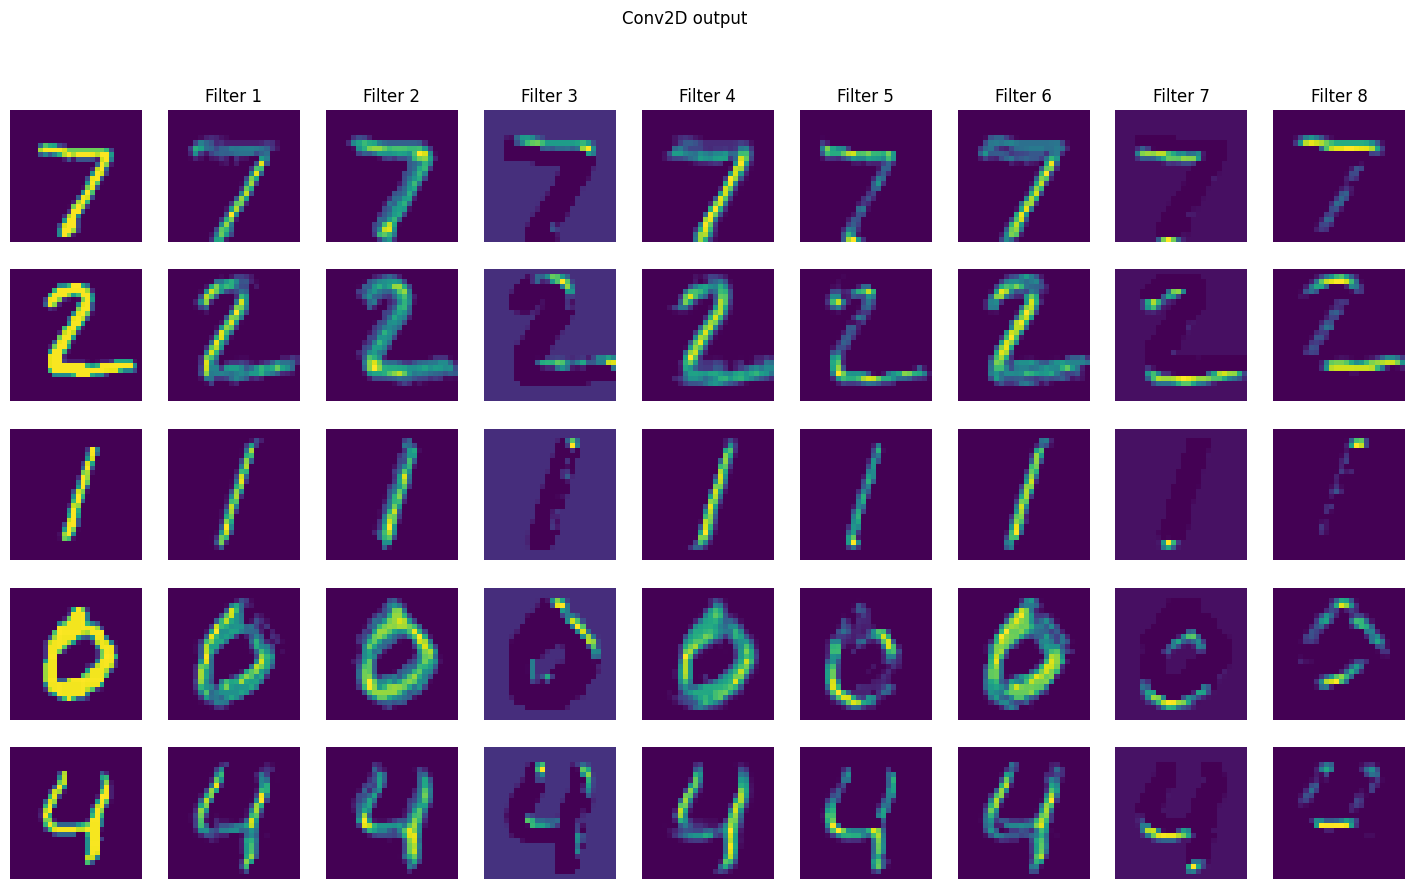

In [17]:
fig, ax = plt.subplots(num_images, num_filters + 1, figsize=((num_filters + 1) * 2, num_images * 2))

for num in range(0, num_images):
    ax[num][0].imshow(x_test[num], cmap='viridis')
    ax[num][0].axis('off')
    # Iterate over the filters and plot each one
    for i in range(1, num_filters + 1):
        ax[num][i].imshow(visualized_outputs[0][num][:, :, i - 1    ], cmap='viridis')
        ax[num][i].axis('off')
        if num == 0:
            ax[num][i].set_title(f'Filter {i}')

    plt.suptitle('Conv2D output')
plt.show()
